```
|--work_space 
    |--Pytorchvideo
    |--Slowfast
        |--configs
            |--Kinetics
                |--MVITv2_B_32x3.yaml
                ...
            ...
        ...
        |--setup.py
    |--detectron2_repo
    |--data
        |--test
        |--train
        |--sample_submission.csv
        |--test.csv
        |--train.csv



In [ ]:
!mkdir work_space
%cd work_space
!pip uninstall simplejson --y
!pip install simplejson 
!pip uninstall flask --y
!pip install flask
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!export PYTHONPATH=./detectron2_repo/detectron2:$PYTHONPATH
!pip install -e detectron2_repo
!git clone https://github.com/facebookresearch/pytorchvideo.git Pytorchvideo
!export PYTHONPATH=./Pytorchvideo/pytorchvide:$PYTHONPATH 
%cd Pytorchvideo
!pip install -e .
%cd ..
!git clone https://github.com/facebookresearch/slowfast Slowfast
!export PYTHONPATH=./Slowfast/slowfast:$PYTHONPATH

In [ ]:
%cd Slowfast
# ./Slowfast/setup.py : PIL, sklearn -> pillow, scikit-learn변경, 실행 후 런타임 다시 시작
!python setup.py build develop

In [ ]:
!unzip /content/drive/MyDrive/dacon/car_crash/open.zip -d /content/work_space/data
%cd work_space

In [ ]:
import random
import pandas as pd
import numpy as np
import math
import os
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision
import torchvision.models as models

# from pytorchvideo.models.hub import vision_transformers as video_mvit
from pytorchvideo.losses.soft_target_cross_entropy import SoftTargetCrossEntropyLoss

from slowfast.models.build import build_model
from slowfast.config.defaults import get_cfg
from slowfast.datasets.mixup import MixUp 

from tqdm.auto import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

CFG = {
    'VIDEO_LENGTH':50, # 10프레임 * 5초
    'RES_IMG_SIZE':112,
    'IMG_SIZE':224,
    'BASE_EPOCHS':30,
    'WEATHER_EPOCHS':50,
    'SLOWFAST_BATCH_SIZE':16,
    'RES_BATCH_SIZE':8,
    'MVIT_BATCH_SIZE':6,
    'TEST_BATCH_SIZE':6,
    'LEARNING_RATE':1e-4,
    'SEED':41
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

crash_MODEL_PATH = '/content/drive/MyDrive/dacon/car_crash/save_model/crash_ego_Involve/'
weather_MODEL_PATH = '/content/drive/MyDrive/dacon/car_crash/save_model/weather/'
timing_MODEL_PATH = '/content/drive/MyDrive/dacon/car_crash/save_model/timing/'

mvit2_model_cfg = './Slowfast/configs/Kinetics/MVITv2_B_32x3.yaml'
mvit2_checkpoint_path = '/content/drive/MyDrive/dacon/car_crash/save_model/weather/MViTv2_B_32x3_k400_f304025456.pyth'

In [ ]:
rain = [272, 373, 415, 657, 725, 761, 783, 846, 1027, 1133, 1420, 1695, 2356, 2480, 2513, 2541, 2596, 2604, 2635, 2654]
# rain = [272, 657, 1027, 1420, 2356, 2480, 2541, 2596, 2654]

snow = [225, 232, 246, 247, 248, 314, 482, 518, 713, 850, 2147]

normal = [4, 17, 21, 56, 108, 126, 144, 149, 172, 190, 221, 234, 238, 263, 283, 306, 332, 341, 349, 374, 375, 400, 402, 419, 488, 495,
          507, 520, 545, 554, 563, 588, 620, 621, 630, 636, 645, 652, 668, 684, 693, 718, 720, 728, 740, 747, 748, 771, 778, 789, 792, 793, 799, 804,
          805, 856, 858, 861, 875, 877, 889, 890, 892, 896, 899, 917, 920, 920, 970, 978, 1018, 1041, 1060, 1061, 1076, 1081, 1086, 1098, 1126,
          1127, 1169, 1172, 1182, 1193, 1224, 1251, 1263, 1270, 1280, 1287, 1301, 1328, 1333, 1423, 1439, 1467, 1488, 1492, 1506, 1531, 1533, 1542,
          1555, 1559, 1581, 1586, 1605, 1636, 1654, 1656, 1698, 1699, 1703, 1718, 1727, 1728, 1771, 1773, 1786, 1795, 1839, 1848, 1849, 1851, 1874,
          1904, 1917, 1923, 1940, 1944, 1949, 1955, 1972, 1975, 2042, 2046, 2051, 2059, 2040, 2180, 2186, 2193, 2198, 2230, 2236,  2239, 2249, 2352,
          2388, 2391, 2449, 2451, 2486, 2532, 2534, 2570, 2571, 2603, 2607, 2615, 2626, 2645, 2647, 2669, 2685]

drop_weather = rain + snow + normal

def crash_transform(label):
    if label == 0 :
        label = 0
    elif label >= 7:
        label = 1
    else:
        label = 2
    return label

def weather_transform(label):
    if label in [1, 2, 7, 8]:
        label = 0
    elif label in [3, 4, 9, 10]:
        label = 1
    elif label in [5, 6, 11, 12]:
        label = 2
    return label

df = pd.read_csv('./data/train.csv')

# crash no = 0, ego_Involve no = 1, ego_Involve yes = 2
crash_ego_Involve_df = df.copy()
crash_ego_Involve_df['label'] = crash_ego_Involve_df['label'].apply(lambda label : crash_transform(label))

# timimg : day = 0, night = 1
timing_df = df.loc[df['label'] != 0]
timing_df['label'] = timing_df['label'].apply(lambda label : 0 if label in [1, 3, 5, 7, 9, 11] else 1)

# weather : Normal = 0, Snowy = 1, Rainy= 2 
weather_df = df.loc[df['label'] != 0]
# noise_weather_drop_df = weather_df.drop(index=drop_weather)  
# noise_weather_drop_df['label'] = noise_weather_drop_df['label'].apply(lambda label : weather_transform(label))

crash_ego_Involve_train_set, crash_ego_Involve_val_set, _, _ = train_test_split(crash_ego_Involve_df, 
                                                                                crash_ego_Involve_df['label'], 
                                                                                test_size=0.2, 
                                                                                random_state=CFG['SEED'])

timing_train_set, timing_val_set, _, _ = train_test_split(timing_df, 
                                            timing_df['label'], 
                                            test_size=0.2, 
                                            random_state=CFG['SEED'])

weather_train_set, weather_val_set, _, _ = train_test_split(weather_df, 
                                            weather_df['label'], 
                                            test_size=0.2, 
                                            random_state=CFG['SEED'])

# weather_train_set2, weather_val_set2, _, _ = train_test_split(noise_weather_drop_df, 
#                                             noise_weather_drop_df['label'], 
#                                             test_size=0.2, 
#                                             random_state=CFG['SEED'])

weather_train_set['label'] = weather_train_set['label'].apply(lambda label : weather_transform(label)) 
weather_train_set['sample_id'] = weather_train_set['sample_id'].apply(lambda sample_id : None if int(sample_id[6:]) in drop_weather else sample_id)
weather_train_set = weather_train_set.dropna(axis=0)
weather_val_set['label'] = weather_val_set['label'].apply(lambda label : weather_transform(label))
weather_val_set['sample_id'] = weather_val_set['sample_id'].apply(lambda sample_id : None if int(sample_id[6:]) in drop_weather else sample_id)
weather_val_set = weather_val_set.dropna(axis=0)

실수로 weather training을 위해 데이터 전처리 과정에서 train_test_split을 사용해 train, val 데이터로 분리한 후 노이즈를 제거한 데이터를 학습에 사용했습니다.
다행히도 데이터를 분리한 후 노이즈를 제거한 데이터와 먼저 노이즈를 제거한 후 분리한 데이터의 비율이 크게 차이가 없어 개의치 않고 학습을 진행하였습니다.

In [ ]:
# train_test_split 이후 label drop
print('클래스 분포 \n', weather_train_set['label'].value_counts(), '\n', weather_val_set['label'].value_counts())

print('Train 데이터 비율:', weather_train_set['label'].value_counts().sum()/(weather_train_set['label'].value_counts().sum()+weather_val_set['label'].value_counts().sum()))
print('Val 데이터 비율:', weather_val_set['label'].value_counts().sum()/(weather_train_set['label'].value_counts().sum()+weather_val_set['label'].value_counts().sum()))

클래스 분포 
 0    438
1     99
2     38
Name: label, dtype: int64 
 0    114
1     19
2     12
Name: label, dtype: int64
Train 데이터 비율: 0.7986111111111112
Val 데이터 비율: 0.2013888888888889


In [ ]:
# label drop 이후 train_test_split 
print('클래스 분포 \n', weather_train_set2['label'].value_counts(), '\n', weather_val_set2['label'].value_counts())

print('Train 데이터 비율:', weather_train_set2['label'].value_counts().sum()/(weather_train_set2['label'].value_counts().sum()+weather_val_set2['label'].value_counts().sum()))
print('Val 데이터 비율:', weather_val_set2['label'].value_counts().sum()/(weather_train_set2['label'].value_counts().sum()+weather_val_set2['label'].value_counts().sum()))

클래스 분포 
 0    440
1     93
2     43
Name: label, dtype: int64 
 0    112
1     25
2      7
Name: label, dtype: int64
Train 데이터 비율: 0.8
Val 데이터 비율: 0.2


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, video_path_list, label_list, label_type=None, transform=None, model_type=None, test=False):
        self.video_path_list = video_path_list
        self.label_list = label_list
        self.label_type = label_type
        self.transform = transform
        self.model_type = model_type
        self.num_frame = 32
        self.slowfast_alpha = 4  # slowfast모델의 입력으로 사용되는 slowframe 파라미터   
        self.test = test

        if self.test:                 # val, test시 5초 영상 그대로 샘플링
            self.start_frame = [0]
            self.end_frame = [50]
        else:                         # training시 영상 앞단 1초 잘라서 샘플링, timing class는 영상 원본 그대로 사용 
            self.start_frame = [10]
            self.end_frame = [50]

    def __getitem__(self, index):
        if self.model_type == 'slowfast':
            self.num_frame = 32
            frames = self.get_video(self.video_path_list[index], self.start_frame, self.end_frame)
            slow_frames = self.uniform_temporal_subsample(frames, frames.shape[1] // self.slowfast_alpha)
            frames = [slow_frames, frames]

        elif self.model_type == 'mvit2':
            self.num_frame = 50 if self.test else 32
            frames = [self.get_video(self.video_path_list[index], self.start_frame, self.end_frame)]

        elif self.model_type == 'res':
            self.start_frame = [0]
            self.end_frame = [50]
            self.num_frame = 50
            frames = self.get_video(self.video_path_list[index], self.start_frame, self.end_frame)

        if self.label_list is not None:
            label = self.label_list[index]
            if self.label_type == 'binary':
                return frames, torch.FloatTensor([label])
            elif self.label_type == 'multi':
                return frames, label 
        else:
            return frames

    def __len__(self):
        return len(self.video_path_list)
    
    def get_video(self, path, start_frame=[0], end_frame=[50]):
        frames = []
        for start, end in zip(start_frame, end_frame):
            cap = cv2.VideoCapture('./data' + path[1:])
            cap.set(cv2.CAP_PROP_POS_FRAMES, start)
            for _ in range(CFG['VIDEO_LENGTH'] - start):
                _, image = cap.read()
                if cap.get(cv2.CAP_PROP_POS_FRAMES) <= end:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    frames.append(image)
            cap.release()
        frames = self.video_transform(frames)
        frames = torch.FloatTensor(frames).permute(3, 0, 1, 2)
        frames = self.uniform_temporal_subsample(frames, self.num_frame)
        return frames

    def video_transform(self, frame_list):
        frames = {'image':' '}
        frames.update({'image'+str(i):'image' for i in range(1, len(frame_list))})
        for i, key in enumerate(frames):
            frames[key] = frame_list[i]
        transformed_frame = self.transform(**frames)
        return np.array(list(transformed_frame.values()))

    def uniform_temporal_subsample(self, x, num_samples, temporal_dim=-3):
        t = x.shape[temporal_dim]
        indices = torch.linspace(0, t - 1, num_samples, device=x.device)
        indices = torch.clamp(indices, 0, t - 1).long()
        return torch.index_select(x, temporal_dim, indices)

In [ ]:
def make_weights(labels, nclasses):
    labels = np.array(labels) 
    weight_arr = np.zeros_like(labels) 
    
    _, counts = np.unique(labels, return_counts=True) 
    for cls in range(nclasses):
        weight_arr = np.where(labels == cls, 1/counts[cls], weight_arr) 

    return weight_arr

crash_weights = make_weights(crash_ego_Involve_train_set['label'].values, len(np.unique(crash_ego_Involve_train_set['label'])))
crash_weights = torch.DoubleTensor(crash_weights)
crash_sampler = torch.utils.data.sampler.WeightedRandomSampler(crash_weights, len(crash_weights))

timing_weights = make_weights(timing_train_set['label'].values, len(np.unique(timing_train_set['label'])))
timing_weights = torch.DoubleTensor(timing_weights)
timing_sampler = torch.utils.data.sampler.WeightedRandomSampler(timing_weights, len(timing_weights))

weather_weights = make_weights(weather_train_set['label'].values, len(np.unique(weather_train_set['label'])))
weather_weights = torch.DoubleTensor(weather_weights)
weather_sampler = torch.utils.data.sampler.WeightedRandomSampler(weather_weights, len(weather_weights))

# crash_class_weights = torch.FloatTensor(compute_class_weight(class_weight = "balanced" , classes=np.unique(crash_ego_Involve_train_set['label']), y = crash_ego_Involve_train_set['label'])).to(device)
# weather_class_weights = torch.FloatTensor(compute_class_weight(class_weight = "balanced" , classes=np.unique(weather_train_set['label']), y = weather_train_set['label'])).to(device)
# timing_class_weights = torch.FloatTensor(compute_class_weight(class_weight = "balanced" , classes=np.unique(timing_train_set['label']), y = timing_train_set['label'])).to(device)

In [ ]:
res_mean = (0.43216, 0.394666, 0.37645)
res_std = (0.22803, 0.22145, 0.216989)

slowfast_mvit_mean = (0.45, 0.45, 0.45)
slowfast_mvit_std = (0.225, 0.225, 0.225)

res_train_transform = A.Compose([
                    A.Resize(CFG['RES_IMG_SIZE'],CFG['RES_IMG_SIZE']),

                    A.OneOf([
                            A.HorizontalFlip(always_apply=False, p=1.0),
                            A.RandomRotate90(always_apply=False, p=1.0)],
                            p=0.6),
                    A.GaussNoise(always_apply=False, p=0.5, var_limit=(50.00, 100.00), per_channel=True, mean=0.0),
                    A.RGBShift(always_apply=False, p=0.4, r_shift_limit=(-10, 10), g_shift_limit=(-10, 10), b_shift_limit=(-10, 10)),
                    A.Normalize(mean=res_mean , std=res_std, max_pixel_value=255.0, always_apply=False, p=1.0),
                    ],
                    additional_targets={'image'+str(i):'image' for i in range(1, 50)}
                    )

res_test_transform = A.Compose([
                    A.Resize(CFG['RES_IMG_SIZE'],CFG['RES_IMG_SIZE']),
                    A.Normalize(mean=res_mean , std=res_std, max_pixel_value=255.0, always_apply=False, p=1.0),
                    ],
                    additional_targets={'image'+str(i):'image' for i in range(1, 50)}
                    )

slowfast_mvit_train_transform = A.Compose([
                    A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),

                    A.OneOf([
                            A.HorizontalFlip(always_apply=False, p=1.0),
                            A.RandomRotate90(always_apply=False, p=1.0)],
                            p=0.6),
                    A.GaussNoise(always_apply=False, p=0.5, var_limit=(50.00, 100.00), per_channel=True, mean=0.0),
                    A.RGBShift(always_apply=False, p=0.4, r_shift_limit=(-10, 10), g_shift_limit=(-10, 10), b_shift_limit=(-10, 10)),
                    A.Normalize(mean=slowfast_mvit_mean , std=slowfast_mvit_std, max_pixel_value=255.0, always_apply=False, p=1.0),
                    ],
                    additional_targets={'image'+str(i):'image' for i in range(1, 50)}
                    )

slowfast_mvit_test_transform = A.Compose([
                    A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                    A.Normalize(mean=slowfast_mvit_mean , std=slowfast_mvit_std, max_pixel_value=255.0, always_apply=False, p=1.0),
                    ],
                    additional_targets={'image'+str(i):'image' for i in range(1, 50)}
                    )

crash_train_dataset = CustomDataset(crash_ego_Involve_train_set['video_path'].values, crash_ego_Involve_train_set['label'].values, 
                              label_type='multi', transform=slowfast_mvit_train_transform, model_type='slowfast', test=False)
crash_train_loader = DataLoader(crash_train_dataset, batch_size = CFG['SLOWFAST_BATCH_SIZE'], shuffle=False, sampler=crash_sampler, num_workers=4)
crash_val_dataset = CustomDataset(crash_ego_Involve_val_set['video_path'].values, crash_ego_Involve_val_set['label'].values, 
                            label_type='multi', transform=slowfast_mvit_test_transform, model_type='slowfast', test=True)
crash_val_loader = DataLoader(crash_val_dataset, batch_size = CFG['SLOWFAST_BATCH_SIZE'], shuffle=False, num_workers=4)

timing_train_dataset = CustomDataset(timing_train_set['video_path'].values, timing_train_set['label'].values, 
                              label_type='binary', transform=res_train_transform, model_type='res', test=False)
timing_train_loader = DataLoader(timing_train_dataset, batch_size = CFG['RES_BATCH_SIZE'], shuffle=False, sampler=timing_sampler, num_workers=4)
timing_val_dataset = CustomDataset(timing_val_set['video_path'].values, timing_val_set['label'].values, 
                            label_type='binary', transform=res_test_transform, model_type='res', test=True)
timing_val_loader = DataLoader(timing_val_dataset, batch_size = CFG['RES_BATCH_SIZE'], shuffle=False, num_workers=4)

weather_train_dataset = CustomDataset(weather_train_set['video_path'].values, weather_train_set['label'].values, 
                          label_type='multi', transform=slowfast_mvit_train_transform, model_type='mvit2', test=False)
weather_train_loader = DataLoader(weather_train_dataset, batch_size = CFG['MVIT_BATCH_SIZE'], shuffle=False, sampler=weather_sampler, num_workers=4)
weather_val_dataset = CustomDataset(weather_val_set['video_path'].values, weather_val_set['label'].values, 
                            label_type='multi', transform=slowfast_mvit_test_transform, model_type='mvit2', test=True)
weather_val_loader = DataLoader(weather_val_dataset, batch_size = CFG['MVIT_BATCH_SIZE'], shuffle=False, num_workers=4)

**MIXUP example**

In [ ]:
mixup_fn = MixUp(
        mixup_alpha=1.0,
        cutmix_alpha=0.0,
        mix_prob=1.0,
        switch_prob=0.5,
        label_smoothing=0.1,
        num_classes=3)

In [ ]:
sample_loader_iter = iter(weather_train_loader)
sample_img, sample_label = next(sample_loader_iter)
sample_label

tensor([2, 0, 1, 1, 0, 0])

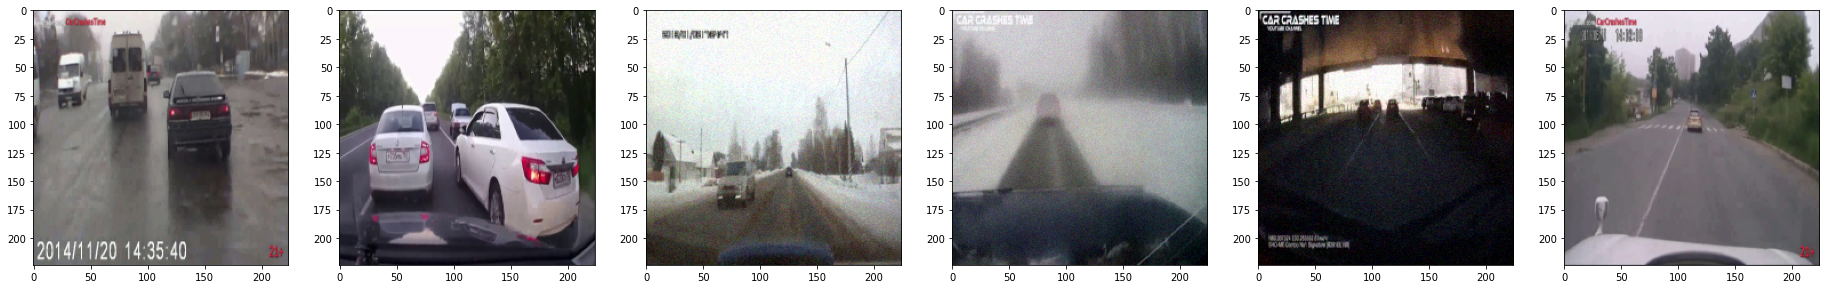

In [ ]:
sample_img_ = sample_img[0].permute(0, 2, 3, 4, 1)
plt.figure(figsize=(32,32))
plt.subplot(1, 6, 1)  
plt.imshow(sample_img_[0, 0, :, :, :].numpy() * slowfast_mvit_std + slowfast_mvit_mean)
plt.subplot(1, 6, 2)  
plt.imshow(sample_img_[1, 0, :, :, :].numpy() * slowfast_mvit_std + slowfast_mvit_mean)
plt.subplot(1, 6, 3)  
plt.imshow(sample_img_[2, 0, :, :, :].numpy() * slowfast_mvit_std + slowfast_mvit_mean)
plt.subplot(1, 6, 4)  
plt.imshow(sample_img_[3, 0, :, :, :].numpy() * slowfast_mvit_std + slowfast_mvit_mean)
plt.subplot(1, 6, 5)  
plt.imshow(sample_img_[4, 0, :, :, :].numpy() * slowfast_mvit_std + slowfast_mvit_mean)
plt.subplot(1, 6, 6)  
plt.imshow(sample_img_[5, 0, :, :, :].numpy() * slowfast_mvit_std + slowfast_mvit_mean)

In [ ]:
sample_img[0], sample_label = mixup_fn(sample_img[0], sample_label)
sample_label

tensor([[0.4454, 0.0333, 0.5212],
        [0.9333, 0.0333, 0.0333],
        [0.0333, 0.9333, 0.0333],
        [0.0333, 0.9333, 0.0333],
        [0.9333, 0.0333, 0.0333],
        [0.5212, 0.0333, 0.4454]])

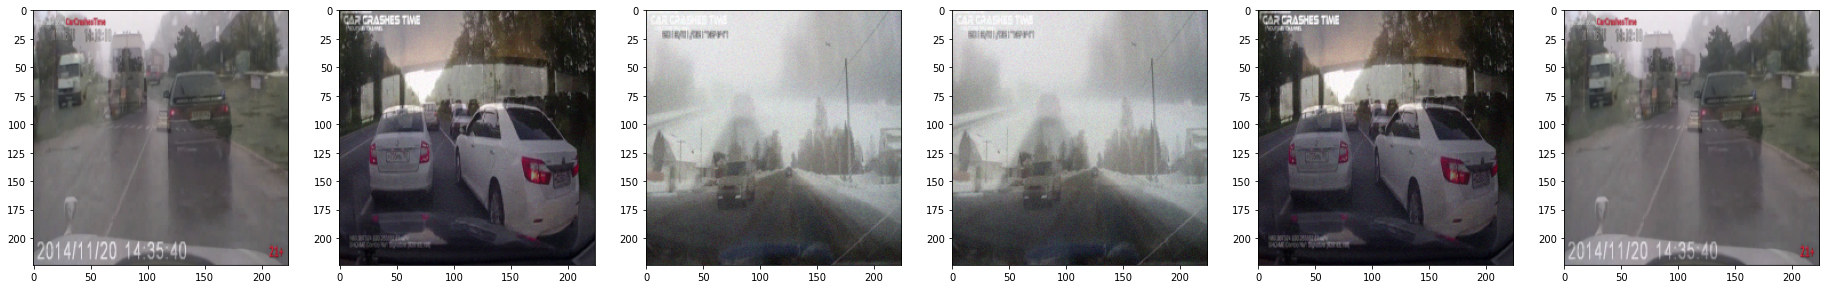

In [ ]:
sample_img__ = sample_img[0].permute(0, 2, 3, 4, 1)
plt.figure(figsize=(32,32))
plt.subplot(1, 6, 1)  
plt.imshow(sample_img__[0, 0, :, :, :].numpy() * slowfast_mvit_std + slowfast_mvit_mean)
plt.subplot(1, 6, 2)  
plt.imshow(sample_img__[1, 0, :, :, :].numpy() * slowfast_mvit_std + slowfast_mvit_mean)
plt.subplot(1, 6, 3)  
plt.imshow(sample_img__[2, 0, :, :, :].numpy() * slowfast_mvit_std + slowfast_mvit_mean)
plt.subplot(1, 6, 4)  
plt.imshow(sample_img__[3, 0, :, :, :].numpy() * slowfast_mvit_std + slowfast_mvit_mean)
plt.subplot(1, 6, 5)  
plt.imshow(sample_img__[4, 0, :, :, :].numpy() * slowfast_mvit_std + slowfast_mvit_mean)
plt.subplot(1, 6, 6)  
plt.imshow(sample_img__[5, 0, :, :, :].numpy() * slowfast_mvit_std + slowfast_mvit_mean)

**MODEL**

In [ ]:
class Crash_Classification_Model(nn.Module):
    def __init__(self, num_classes=3, backbone_name='slowfast', model_cfg=None, checkpoint_path=None, pretrained=True):
        super(Crash_Classification_Model, self).__init__()
        if backbone_name == 'slowfast':
            self.backbone = torch.hub.load("facebookresearch/pytorchvideo:main", model='slowfast_r101', pretrained=pretrained)
            output_dim = 400

        self.crash_classifier = nn.Sequential(
                                      nn.Linear(output_dim, 256),
                                      nn.LeakyReLU(),
                                      nn.Linear(256, num_classes))        
    def forward(self, x):
        x = self.backbone(x)
        x = self.crash_classifier(x)
        return x
        
class Timing_Classification_Model(nn.Module):
    def __init__(self, num_classes=1, backbone_name='res', model_cfg=None, pretrained=True):
        super(Timing_Classification_Model, self).__init__()
        if backbone_name == 'res':
            self.backbone = models.video.r2plus1d_18(weights=models.video.R2Plus1D_18_Weights.KINETICS400_V1)
            self.backbone.fc = nn.Identity()
            output_dim = 512

        self.timing_classifier = nn.Sequential(
                                      nn.Dropout(0.3),
                                      nn.Linear(output_dim, 256),
                                      nn.LeakyReLU(),
                                      nn.Linear(256, num_classes))        
    def forward(self, x):
        x = self.backbone(x)
        x = self.timing_classifier(x)
        return x

class Weather_Classification_Model(nn.Module):
    def __init__(self, num_classes=3, backbone_name='mvit2', model_cfg=None, checkpoint_path=None, pretrained=True, device=torch.device('cuda')):
        super(Weather_Classification_Model, self).__init__()
        if backbone_name == 'mvit2':
            self.backbone = self.get_mvit2(model_cfg, num_classes, checkpoint_path, pretrained, device)

    def get_mvit2(self, model_cfg, num_classes, checkpoint_path, pretrained, device):
        cfg = get_cfg()
        cfg.merge_from_file(model_cfg)
        cfg.NUM_GPUS = 1 if device.type == 'cuda' else 0
        model = build_model(cfg)

        if pretrained:
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state'])
            print('load model')
        model.head = nn.Sequential(
                            nn.Dropout(0.3),
                            nn.Linear(768, num_classes, bias=True))
        return model

    def forward(self, x):
        x = self.backbone(x)
        return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.stop = False
        self.val_acc_max = np.Inf
        self.delta = delta
        self.trace_func = trace_func

    def __call__(self, val_acc):

        score = val_acc
        update_info = bool()

        if self.best_score is None:
            self.best_score = score
            update_info = True
            return update_info

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            update_info = False
            if self.counter >= self.patience:
                self.stop = True
            return update_info

        else:
            self.best_score = score
            self.counter = 0
            update_info = True
            return update_info

def get_lr_at_epoch(cur_epoch, warmup_epoch=10, max_epcoh=50):
    lr = lr_func_cosine(cur_epoch, offset=warmup_epoch, max_epcoh=max_epcoh)
    # Perform warm up.
    if cur_epoch < warmup_epoch:
        lr_start = 1e-6
        lr_end = lr_func_cosine(warmup_epoch, offset=warmup_epoch, max_epcoh=max_epcoh)
        alpha = (lr_end - lr_start) / warmup_epoch
        lr = cur_epoch * alpha + lr_start
    return lr

def lr_func_cosine(cur_epoch, base_lr=0.0001, offset=10, max_epcoh=50):
    return (1e-6 + (base_lr - 1e-6) * (math.cos(
                math.pi * (cur_epoch - offset) / (max_epcoh - offset)) + 1.0 ) * 0.5)
    
def set_lr(optimizer, new_lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = new_lr

def convert_smoothing_label(targets, smoothing=0.1, num_classes=3):
    off_value = smoothing / num_classes
    on_value = 1.0 - smoothing + off_value

    targets = targets.long().view(-1, 1)
    return torch.full((targets.size()[0], num_classes), off_value, device=targets.device
                      ).scatter_(1, targets, on_value)              

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, early_stopping, device, class_name, epochs):
    model.to(device)
    
    if class_name == 'weather':
        criterion = SoftTargetCrossEntropyLoss(normalize_targets=False).to(device)
        warmup_epoch = 10
        num_classes = 3
        mix_prob = 1.0
        CLS_MODEL_PATH = weather_MODEL_PATH
    elif class_name == 'crash':
        criterion = SoftTargetCrossEntropyLoss(normalize_targets=False).to(device)
        warmup_epoch = 5
        num_classes = 3
        mix_prob = 0.0
        CLS_MODEL_PATH = crash_MODEL_PATH
    elif class_name == 'timing':
        criterion = nn.BCEWithLogitsLoss().to(device)
        warmup_epoch = None
        num_classes = 1
        mix_prob = 0.0
        CLS_MODEL_PATH = timing_MODEL_PATH

    mixup_fn = MixUp(
            mixup_alpha=0.8,
            cutmix_alpha=1.0,
            mix_prob=mix_prob,
            switch_prob=0.5,
            label_smoothing=0.1,
            num_classes=num_classes,
        )

    best_val_score = 0
    best_model = None

    for epoch in range(epochs):
        model.train()
        train_loss = []
        
        for iteration, (videos, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            if class_name in ['crash', 'weather']:
                epoch_exact = epoch + float(iteration) / len(train_loader)
                new_lr = get_lr_at_epoch(epoch_exact, warmup_epoch, max_epcoh=epochs)
                set_lr(optimizer, new_lr)
            
            if isinstance(videos, (list,)):
                for i in range(len(videos)):
                    if isinstance(videos[i], (list,)):
                        for j in range(len(videos[i])):
                            videos[i][j] = videos[i][j].to(device)
                    else:
                        videos[i] = videos[i].to(device)
            else:
                videos = videos.to(device)

            labels = labels.to(device)

            if class_name == 'weather':
                videos[0], labels = mixup_fn(videos[0], labels)
            elif class_name == 'crash':
                labels = convert_smoothing_label(labels, smoothing=0.1, num_classes=num_classes)
            elif class_name == 'timing':
                pass

            optimizer.zero_grad()

            output = model(videos)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_score_macro, _val_acc = validation(model, val_loader, device, class_name)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch+1}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1-macro : [{_val_score_macro:.5f}] Val acc : [{_val_acc:.5f}]')

        if early_stopping(_val_score_macro):
            best_model = model
            best_epoch = epoch+1
          
        if early_stopping.stop:
              break

        if (epoch+1) % 10 == 0:  
            torch.save(best_model, f'{CLS_MODEL_PATH}{class_name}_epoch{best_epoch}.pt')
       
        if scheduler is not None:
            scheduler.step(_val_score_macro)

    return best_model

def validation(model, val_loader, device, class_name):
    model.eval()
    val_loss = []
    preds, trues = [], []

    if class_name in ['crash', 'weather']:
        criterion = nn.CrossEntropyLoss().to(device)
    else:
        criterion = nn.BCEWithLogitsLoss().to(device)
  
    with torch.no_grad():
        for videos, labels in tqdm(iter(val_loader)):
            if isinstance(videos, (list,)):
                for i in range(len(videos)):
                    if isinstance(videos[i], (list,)):
                        for j in range(len(videos[i])):
                            videos[i][j] = videos[i][j].to(device)
                    else:
                        videos[i] = videos[i].to(device)
            else:
                videos = videos.to(device)

            labels = labels.to(device)

            if class_name == 'weather':      
                videos1, videos2, videos3, videos4, videos5 = videos[0][:, :, :32, :, :], videos[0][:, :, 5:37, :, :], videos[0][:, :, 10:42, :, :], \
                                                              videos[0][:, :, 15:47, :, :], videos[0][:, :, 18:50, :, :]        

                logit1 = model([videos1])
                logit2 = model([videos2])
                logit3 = model([videos3])
                logit4 = model([videos4])
                logit5 = model([videos5])

                loss1 = criterion(logit1, labels)
                loss2 = criterion(logit2, labels)
                loss3 = criterion(logit3, labels)
                loss4 = criterion(logit4, labels)
                loss5 = criterion(logit5, labels)

                loss = (loss1 + loss2 + loss3 + loss4 + loss5) / 5
                
                val_loss.append(loss.item())

                pred1 = logit1.argmax(1).detach().cpu().numpy().tolist()
                pred2 = logit2.argmax(1).detach().cpu().numpy().tolist()
                pred3 = logit3.argmax(1).detach().cpu().numpy().tolist()
                pred4 = logit4.argmax(1).detach().cpu().numpy().tolist()
                pred5 = logit5.argmax(1).detach().cpu().numpy().tolist()

                for pred in zip(pred1, pred2, pred3, pred4, pred5):
                    pred = list(pred)
                    if pred[0] == pred[1] == pred[2] == pred[3] == pred[4]:
                        preds += [pred[0]]
                    else:
                        if 1 in pred and 2 in pred:
                            if pred.count(1) >= pred.count(2): 
                                preds += [1]
                            elif pred.count(1) < pred.count(2): 
                                preds += [2]
                        elif 1 in pred:
                            preds += [1]
                        elif 2 in pred:
                            preds += [2]

                trues += labels.view(-1).detach().cpu().numpy().tolist()

            else:
                logit = model(videos)
                loss = criterion(logit, labels)

                val_loss.append(loss.item())

                if class_name == 'crash':
                    preds += logit.argmax(1).detach().cpu().numpy().tolist()

                elif class_name == 'timing':
                    logit = logit.sigmoid()
                    logit = (logit > 0.5).float()
                    preds += logit.view(-1).detach().cpu().numpy().tolist()

                trues += labels.view(-1).detach().cpu().numpy().tolist()

        _val_loss = np.mean(val_loss)
    _val_score_macro = f1_score(trues, preds, average='macro')
    _val_acc = np.mean(np.array(preds)==np.array(trues))
    return _val_loss, _val_score_macro, _val_acc

**TRAIN**

In [ ]:
class_name = 'crash' 
epochs= CFG['BASE_EPOCHS']
crash_model = Crash_Classification_Model(num_classes=3, backbone_name='slowfast', pretrained=True)
crash_model.eval()
early_stopping = EarlyStopping(patience=15, verbose=False) 
optimizer = torch.optim.AdamW(params = crash_model.parameters(), lr =CFG['LEARNING_RATE'], weight_decay=0.05)
scheduler = None
infer_model = train(crash_model, optimizer, crash_train_loader, crash_val_loader, scheduler, early_stopping, device, class_name, epochs)

In [ ]:
class_name = 'timing'
epochs= CFG['BASE_EPOCHS']
timing_model = Timing_Classification_Model(num_classes=1, backbone_name='res', pretrained=True)
timing_model.eval()
early_stopping = EarlyStopping(patience=10, verbose=False) 
optimizer = torch.optim.Adam(params = timing_model.parameters(), lr =3e-04)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)
infer_model = train(timing_model, optimizer, timing_train_loader, timing_val_loader, scheduler, early_stopping, device, class_name, epochs)

In [ ]:
class_name = 'weather' 
epochs= CFG['WEATHER_EPOCHS']
weather_model = Weather_Classification_Model(num_classes=3, backbone_name='mvit2', model_cfg=mvit2_model_cfg, checkpoint_path=mvit2_checkpoint_path, pretrained=True, device=device)
weather_model.eval()
early_stopping = EarlyStopping(patience=15, verbose=False) 
optimizer = torch.optim.AdamW(params = weather_model.parameters(), lr =CFG['LEARNING_RATE'], weight_decay=0.05)
scheduler = None
infer_model = train(weather_model, optimizer, weather_train_loader, weather_val_loader, scheduler, early_stopping, device, class_name, epochs)

**TEST**

In [ ]:
def inference_timing(model_list, test_loader, device):
    ensemble = []
    for model in (model_list):
        model.to(device)
        model.eval()
        preds = []
        with torch.no_grad():
            for videos in tqdm(iter(test_loader)):
                videos = videos.to(device)
                
                logit = model(videos)

                preds += logit.sigmoid().view(-1).detach().cpu().numpy().tolist()
        ensemble.append(preds)

    ensemble = np.mean(ensemble, axis=0)
    ensemble = (ensemble > 0.5).astype(np.int)
    return ensemble

def inference_crash(model_list, test_loader, device):
    ensemble, ensemble_preds = [], []
    crash_preds, ego_Involve_preds = [], []

    for model in (model_list):
        model.to(device)
        model.eval()
        preds = []

        with torch.no_grad():
            for videos in tqdm(iter(test_loader)):
                videos[0], videos[1] = videos[0].to(device), videos[1].to(device)
                
                logit = model(videos)

                preds.append(logit.softmax(dim=1).detach().cpu().numpy())
        ensemble.append(preds)
    ensemble = np.array(ensemble).mean(axis=0)

    for batch in ensemble:
        ensemble_preds += batch.argmax(axis=1).reshape(-1).tolist()
    for preds in ensemble_preds:
        if preds == 0:
            crash_preds += [0]
            ego_Involve_preds += [-1]
        elif preds == 1:
            ego_Involve_preds += [0]
            crash_preds += [1]
        elif preds == 2:
            ego_Involve_preds += [1]
            crash_preds += [1]
    return crash_preds, ego_Involve_preds

def inference_weather(model_list, test_loader, device):
    def select_class(logits):
        pred = []
        for logit in logits:
            top1_idx = logit.argsort()[-3:][::-1][0]
            top2_idx = logit.argsort()[-3:][::-1][1]
            pred += [top2_idx if top1_idx == 0 and logit[top1_idx] - logit[top2_idx] < 0.20 else top1_idx]
        return pred

    ensemble1, ensemble2, ensemble3, ensemble4, ensemble5 = [], [], [], [], []
    ensemble_preds = []

    for model in (model_list):
        model.to(device)
        model.eval()
        preds1, preds2, preds3, preds4, preds5 = [], [], [], [], []
        with torch.no_grad():
            for videos in tqdm(iter(test_loader)):
                videos[0] = videos[0].to(device)

                videos1, videos2, videos3, videos4, videos5 = videos[0][:, :, :32, :, :], videos[0][:, :, 5:37, :, :], videos[0][:, :, 10:42, :, :], \
                                                          videos[0][:, :, 15:47, :, :], videos[0][:, :, 18:50, :, :]        
                logit1 = model([videos1])
                logit2 = model([videos2])
                logit3 = model([videos3])
                logit4 = model([videos4])
                logit5 = model([videos5])
              
                preds1.append(logit1.softmax(dim=1).detach().cpu().numpy())
                preds2.append(logit2.softmax(dim=1).detach().cpu().numpy())
                preds3.append(logit3.softmax(dim=1).detach().cpu().numpy())
                preds4.append(logit4.softmax(dim=1).detach().cpu().numpy())
                preds5.append(logit5.softmax(dim=1).detach().cpu().numpy())

        ensemble1.append(preds1)
        ensemble2.append(preds2)
        ensemble3.append(preds3)
        ensemble4.append(preds4)
        ensemble5.append(preds5)

    ensemble1 = np.array(ensemble1).mean(axis=0)
    ensemble2 = np.array(ensemble2).mean(axis=0)
    ensemble3 = np.array(ensemble3).mean(axis=0)
    ensemble4 = np.array(ensemble4).mean(axis=0)
    ensemble5 = np.array(ensemble5).mean(axis=0)

    for batch in range(ensemble1.shape[0]):
        pred1 = ensemble1[batch].argmax(axis=1)
        pred2 = ensemble2[batch].argmax(axis=1)
        pred3 = ensemble3[batch].argmax(axis=1)
        pred4 = ensemble4[batch].argmax(axis=1)
        pred5 = ensemble5[batch].argmax(axis=1)
        # pred1 = select_class(ensemble1[batch])
        # pred2 = select_class(ensemble2[batch])
        # pred3 = select_class(ensemble3[batch])
        # pred4 = select_class(ensemble4[batch])
        # pred5 = select_class(ensemble5[batch])

        for pred in zip(pred1, pred2, pred3, pred4, pred5):
            pred = list(pred)
            if pred[0] == pred[1] == pred[2] == pred[3] == pred[4]:
                ensemble_preds += [pred[0]]
            else:
                if 1 in pred and 2 in pred:
                    if pred.count(1) >= pred.count(2): 
                        ensemble_preds += [1]
                    elif pred.count(1) < pred.count(2): 
                        ensemble_preds += [2]
                elif 1 in pred:
                    ensemble_preds += [1]
                elif 2 in pred:
                    ensemble_preds += [2]
    return ensemble_preds

In [ ]:
test = pd.read_csv('./data/test.csv')
crash_test_dataset = CustomDataset(test['video_path'].values, None, transform=slowfast_mvit_test_transform, model_type='slowfast', test=True)
crash_test_loader = DataLoader(crash_test_dataset, batch_size = CFG['TEST_BATCH_SIZE'], shuffle=False, num_workers=2)
timing_test_dataset = CustomDataset(test['video_path'].values, None, transform=res_test_transform, model_type='res', test=True)
timing_test_loader = DataLoader(timing_test_dataset, batch_size = CFG['TEST_BATCH_SIZE'], shuffle=False, num_workers=2)
weather_test_dataset = CustomDataset(test['video_path'].values, None, transform=slowfast_mvit_test_transform, model_type='mvit2', test=True)
weather_test_loader = DataLoader(weather_test_dataset, batch_size = CFG['TEST_BATCH_SIZE'], shuffle=False, num_workers=2)

In [ ]:
# crash_MODEL_PATH = '/content/drive/MyDrive/dacon/car_crash/save_model/crash_ego_Involve/'
# timing_MODEL_PATH = '/content/drive/MyDrive/dacon/car_crash/save_model/timing/'
# weather_MODEL_PATH = '/content/drive/MyDrive/dacon/car_crash/save_model/weather/'

MODEL_PATH  = '/content/drive/MyDrive/dacon/car_crash/save_model/model_save/'

crash_model = Crash_Classification_Model(num_classes=3, backbone_name='slowfast', pretrained=False)
crash_model = torch.load(f'{MODEL_PATH}crash_epoch18.pt', map_location=device)

timing_model = Timing_Classification_Model(num_classes=1, backbone_name='res', pretrained=False)
timing_model = torch.load(f'{MODEL_PATH}timing_epoch18.pt', map_location=device)

checkpoint_path = None
weather_model = Weather_Classification_Model(num_classes=3, backbone_name='mvit2', model_cfg=mvit2_model_cfg, checkpoint_path=checkpoint_path, pretrained=False, device=device)
weather_model = torch.load(f'{MODEL_PATH}weather_epoch11.pt', map_location=device)

In [ ]:
LABEL_INFO = {
              1:[1, 1, 0, 0], 2:[1, 1, 0, 1], 3:[1, 1, 1, 0], 4:[1, 1, 1, 1], 5:[1, 1, 2, 0], 6:[1, 1, 2, 1],
              7:[1, 0, 0, 0], 8:[1, 0, 0, 1], 9:[1, 0, 1, 0], 10:[1, 0, 1, 1], 11:[1, 0, 2, 0], 12:[1, 0, 2, 1]
              }

crash, ego_Involve = inference_crash([crash_model], crash_test_loader, device)
timing = inference_timing([timing_model], timing_test_loader, device)
weather = inference_weather([weather_model], weather_test_loader, device)

preds= []
for label in zip(crash, ego_Involve, weather, timing):
  if label[0] == 0:
      preds += [0]
  else:
      preds += [k for k, v in LABEL_INFO.items() if v == list(label)]

submit = pd.read_csv('./data/sample_submission.csv')

submit['label'] = preds
submit.to_csv('./result.csv', index=False)
submit.head()